Сравнение прогнозов нерегулярных временных рядов с/без фичей по дате.

## Imports

In [234]:
import sys
import os
import warnings
import json
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset

sys.path.append('../')

In [235]:
warnings.filterwarnings('ignore')

## Read Datasets

### Initital datasets

In [236]:
exchange = get_dataset("exchange_rate", regenerate=False)

solar = get_dataset("solar_nips", regenerate=False)

electricity = get_dataset("electricity_nips", regenerate=False)

### Targets/forecasts

In [237]:
MAF_PATH = "../trans_maf/notebooks/reports/maf/run_03/predictions"

MAF_PATH_NO_DATE = "../trans_maf/notebooks/reports/maf/run_02/predictions"

DATASETS = ["solar", "electricity", "exchange"]

### Metrics

In [238]:
# read previous run metrics

previous_metrics = pd.read_parquet(
    '../trans_maf/notebooks/reports/maf/predictions/metrics.parquet'
    ).reset_index(drop=True)

# nans probability column
previous_metrics['model'] = 'trans_maf_no_date_feature'
previous_metrics['nans_prob'] = 0

In [239]:
models = []
metrics = []
metrics_names = []
datasets = []
probs = []

for model_path, model_name, time_feature in zip(
    [MAF_PATH, MAF_PATH_NO_DATE], 
    ['trans_maf_date_feature', 'trans_maf_no_date_feature'], 
    [1, 0]
    ):
    for dataset in DATASETS:
        for nans_prob in np.linspace(0, 0.8, 9):
            nans_prob = float(np.round(nans_prob, 1))
            
            try:
                with open(os.path.join(model_path, f'agg_metrics__{dataset}_{nans_prob}.json')) as f:
                    data = json.load(f)

                    for metric in ["MAPE", "RMSE", "m_sum_mean_wQuantileLoss"]:
                        models.append(model_name)
                        metrics.append(data[metric])
                        metrics_names.append(metric)
                        datasets.append(dataset)
                        probs.append(nans_prob)

            except:
                for metric in ["MAPE", "RMSE", "m_sum_mean_wQuantileLoss"]:
                    models.append(model_name)
                    metrics.append(np.nan)
                    metrics_names.append(metric)
                    datasets.append(dataset)
                    probs.append(nans_prob)
                print(f"No data for {dataset} with nans prob = {nans_prob}")

metrics_df = pd.DataFrame({
    "model": models, 
    "metric": metrics,
    "metric_name": metrics_names,
    "dataset": datasets,
    "nans_prob": probs
})

metrics_df["metric_name"] = metrics_df["metric_name"].replace({
    "m_sum_mean_wQuantileLoss": "CRPS_sum"
})

No data for solar with nans prob = 0.8
No data for electricity with nans prob = 0.1
No data for electricity with nans prob = 0.7
No data for electricity with nans prob = 0.8
No data for solar with nans prob = 0.0
No data for solar with nans prob = 0.4
No data for solar with nans prob = 0.8
No data for electricity with nans prob = 0.0
No data for electricity with nans prob = 0.7
No data for electricity with nans prob = 0.8
No data for exchange with nans prob = 0.0


In [240]:
# concat with previous metrica dataframe (nans probabiloty == 0)

metrics_df = pd.concat([previous_metrics, metrics_df]).reset_index(drop=True)

### Predictions

In [241]:
# # read previous run predictions

with open('../trans_maf/notebooks/reports/maf/predictions/forecasts_targets.pickle', "rb") as fp:
    previous_forecasts = pickle.load(fp)

In [242]:
forecasts = {}

for model_path, model_name in zip(
    [MAF_PATH, MAF_PATH_NO_DATE], 
    ['trans_maf_date_feature', 'trans_maf_no_date_feature']
    ):

    forecasts[model_name] = {}
    
    for dataset in DATASETS:
        forecasts[model_name][dataset] = {}

        for nans_prob in np.linspace(0, 0.8, 9):
            nans_prob = np.round(nans_prob, 1)
            
            forecasts[model_name][dataset][nans_prob] = {}
    
            for ts in ["targets", "forecasts"]:
                
                try:
                    with open(os.path.join(model_path, f'{ts}__{dataset}_{nans_prob}.json'), "rb") as fp:
                        data = pickle.load(fp)

                    forecasts[model_name][dataset][nans_prob][ts] = data
                except:
                    print(f"No data for {dataset} {ts} with nans prob = {nans_prob} ({model_name})")

No data for solar targets with nans prob = 0.8 (trans_maf_date_feature)
No data for solar forecasts with nans prob = 0.8 (trans_maf_date_feature)
No data for electricity targets with nans prob = 0.1 (trans_maf_date_feature)
No data for electricity forecasts with nans prob = 0.1 (trans_maf_date_feature)
No data for electricity targets with nans prob = 0.7 (trans_maf_date_feature)
No data for electricity forecasts with nans prob = 0.7 (trans_maf_date_feature)
No data for electricity targets with nans prob = 0.8 (trans_maf_date_feature)
No data for electricity forecasts with nans prob = 0.8 (trans_maf_date_feature)
No data for solar targets with nans prob = 0.0 (trans_maf_no_date_feature)
No data for solar forecasts with nans prob = 0.0 (trans_maf_no_date_feature)
No data for solar targets with nans prob = 0.4 (trans_maf_no_date_feature)
No data for solar forecasts with nans prob = 0.4 (trans_maf_no_date_feature)
No data for solar targets with nans prob = 0.8 (trans_maf_no_date_feature)
N

In [243]:
# add to forecasts dict nans prob == 0 forecasts

for dataset in DATASETS:
    forecasts['trans_maf_no_date_feature'][dataset][0] = previous_forecasts[dataset]

## Metrics visualisation

In [244]:
all_metrics = {}

for metric in ["MAPE", "RMSE", "CRPS_sum"]:
    all_metrics[metric] = metrics_df[metrics_df["metric_name"] == metric] 

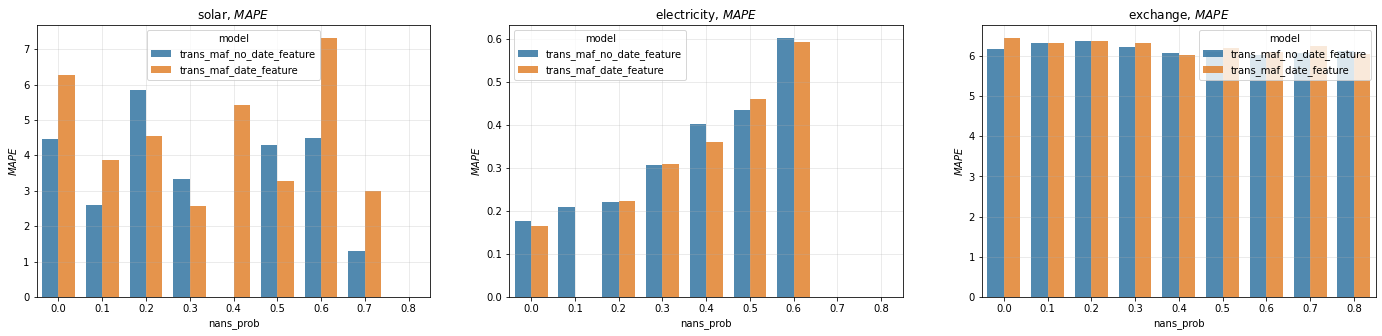

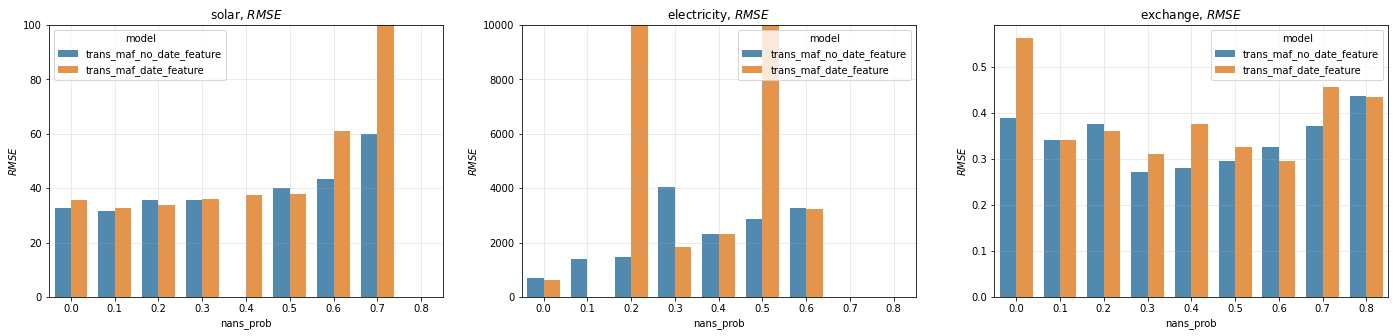

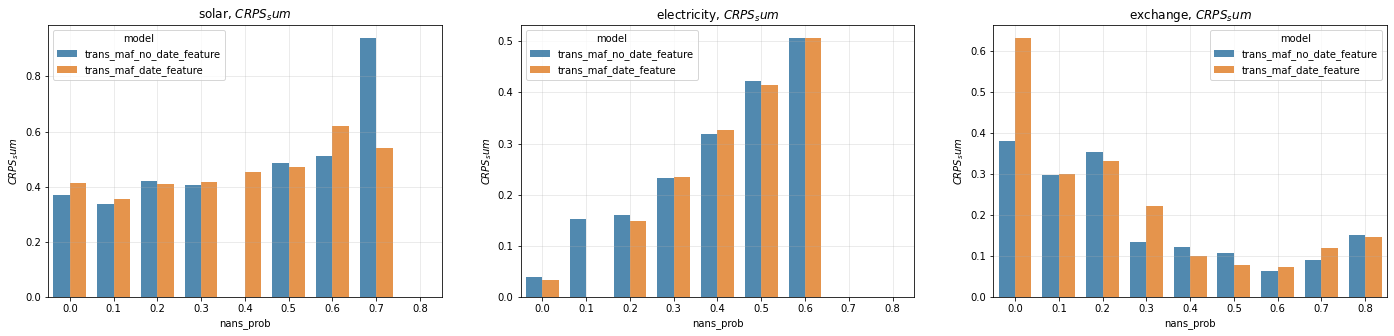

In [245]:
# fig, ax = plt.subplots(3, 3, figsize=(24, 16))

for idx, metric in enumerate(all_metrics):
     
    df = all_metrics[metric]

    fig, ax = plt.subplots(1, 3, figsize=(24, 5))
    
    for (jdx, dataset), color in zip(enumerate(DATASETS), ['tab:blue', 'tab:orange', 'tab:green']):

        sns.barplot(
            df[df['dataset'] == dataset], 
            x='nans_prob', 
            y='metric', 
            hue='model', 
            alpha=0.85, 
            width=0.75, 
            ax=ax[jdx], 
        )

        if dataset == 'solar' and metric == 'RMSE':
            ax[jdx].set_ylim((0, 100))
        if dataset == 'electricity' and metric == 'RMSE':
            ax[jdx].set_ylim((0, 1e4))

        ax[jdx].set_title(f"{dataset}, ${metric}$")
        ax[jdx].grid(alpha=0.3)
        ax[jdx].set_ylabel(f"${metric}$")


## Profiles

In [202]:
def dataset_summary(dataset, targets, forecasts):
    print(f"freq: {dataset.metadata.freq}")
    print(f"prediction length: {dataset.metadata.prediction_length}")
    print(f"n_components: {targets.shape[1]}\n")

    print(f"train start: {targets.index[0]}")
    print(f"train end: {targets.index[-1]}")
    print(f"length: {len(targets)}\n")

    print(f"test start: {forecasts.index[0]}")
    print(f"test end: {forecasts.index[-1]}")
    print(f"length: {len(forecasts)}")

In [203]:
def to_pandas(forecasts, freq):
    whole_test = []

    for i in range(len(forecasts)):

        forecast_length = forecasts[i].samples.shape[1]

        for idx, j in enumerate(forecasts[i].samples):

            dates = pd.date_range(forecasts[i].start_date.to_timestamp(), freq=freq, periods=forecast_length)

            df = pd.DataFrame(j, index=dates)

            df['sample'] = idx

            df[df < 0] = 0

            whole_test.append(df)

    whole_test = pd.concat(whole_test)

    return whole_test

In [207]:
# create dataframes

solar_forecasts = []
electricity_forecasts = []
exchange_forecasts = []

for model in forecasts.keys():

    for dataset_name, dataset, df_storage in zip(
        DATASETS, 
        [solar, electricity, exchange], 
        [solar_forecasts, electricity_forecasts, exchange_forecasts]
        ):

        for nans_prob in np.linspace(0, 0.8, 9):
            nans_prob = np.round(nans_prob, 1)
        
            try:
                cur_forecasts = forecasts[model][dataset_name][nans_prob]['forecasts']
                
                cur_forecasts_df = to_pandas(forecasts=cur_forecasts, freq=dataset.metadata.freq)
                cur_forecasts_df['model'] = model
                cur_forecasts_df['nans_prob'] = nans_prob


                df_storage.append(cur_forecasts_df)
            
            except:
                print(dataset_name, f"{nans_prob}", 'no_data')

solar_forecasts = pd.concat(solar_forecasts)
electricity_forecasts = pd.concat(electricity_forecasts)
exchange_forecasts = pd.concat(exchange_forecasts)

solar 0.8 no_data
electricity 0.1 no_data
electricity 0.7 no_data
electricity 0.8 no_data
solar 0.4 no_data
solar 0.8 no_data
electricity 0.7 no_data
electricity 0.8 no_data


In [208]:
def visualize_targets(targets: pd.DataFrame, name: str):
    targets.plot(figsize=(24, 4), linewidth=0.75)

    plt.grid(alpha=0.3)

    plt.title(f"{name} {targets.shape[1]} components [target].")

    plt.show()

### Solar

#### Dataset Summary

In [210]:
# targets
solar_targets = forecasts['trans_maf_date_feature']['solar'][0.0]['targets']

# forecasts
solar_forecasts_maf = to_pandas(forecasts['trans_maf_date_feature']['solar'][0.0]['forecasts'], freq=solar.metadata.freq)

# test length
solar_test_length = len(solar_forecasts_maf[solar_forecasts_maf['sample'] == 1])

# dataset summary
dataset_summary(solar, solar_targets[0], solar_forecasts_maf[solar_forecasts_maf['sample'] == 1])

freq: H
prediction length: 24
n_components: 137

train start: 2006-01-01 00:00
train end: 2006-10-21 00:00
length: 7033

test start: 2006-10-20 01:00:00
test end: 2006-10-27 00:00:00
length: 168


#### Train/test periods

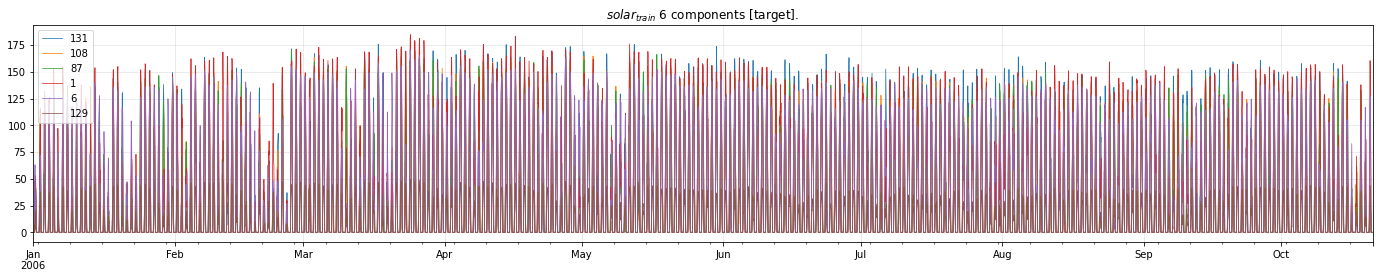

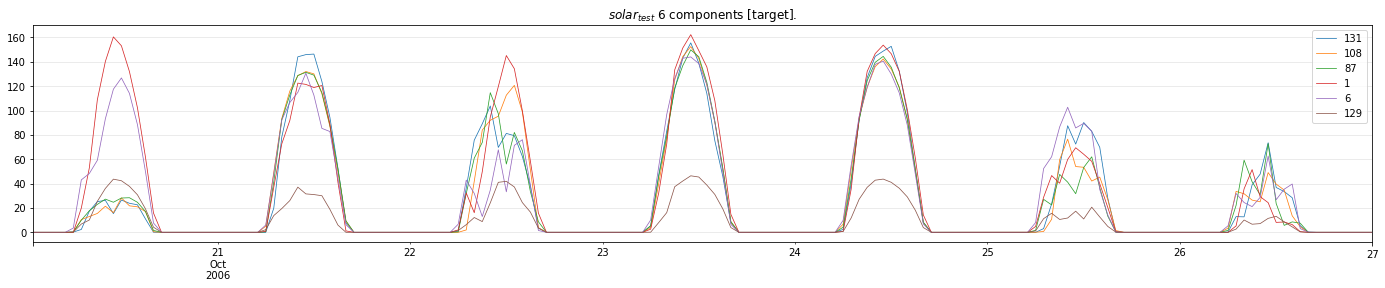

In [211]:
n = 6

solar_components = np.random.choice(range(solar_targets[0].shape[1]), size=n)

visualize_targets(solar_targets[0][solar_components], '$solar_{train}$')
visualize_targets(solar_targets[-1][solar_components].iloc[-solar_test_length:, :], '$solar_{test}$')

#### Actual/forecast visualisation

In [222]:
rename_map = {
    'trans_maf_no_date_feature': 'no_date_feature',
    'trans_maf_date_feature': 'date_feature', 
    }

solar_forecasts['model'] = solar_forecasts['model'].map(rename_map)

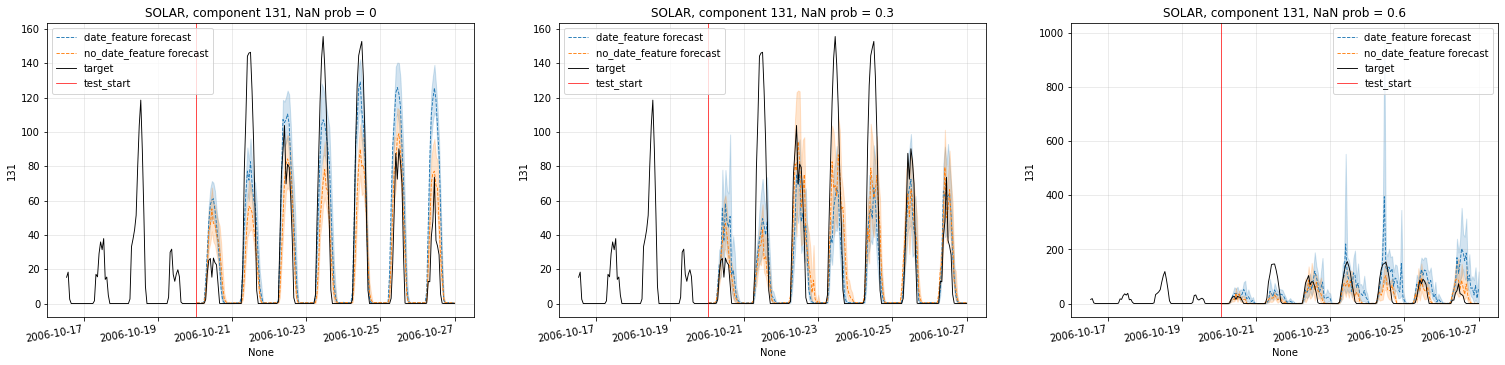

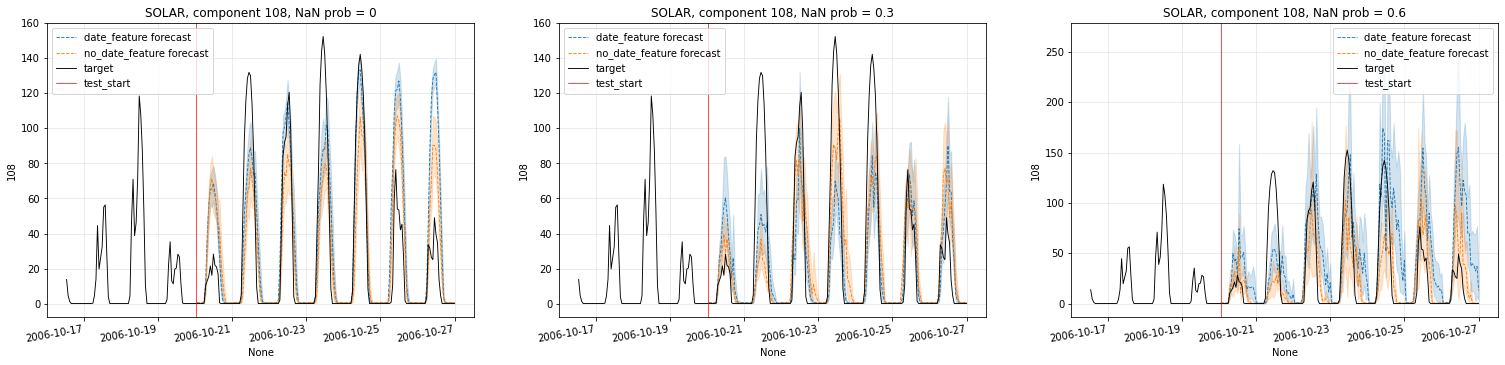

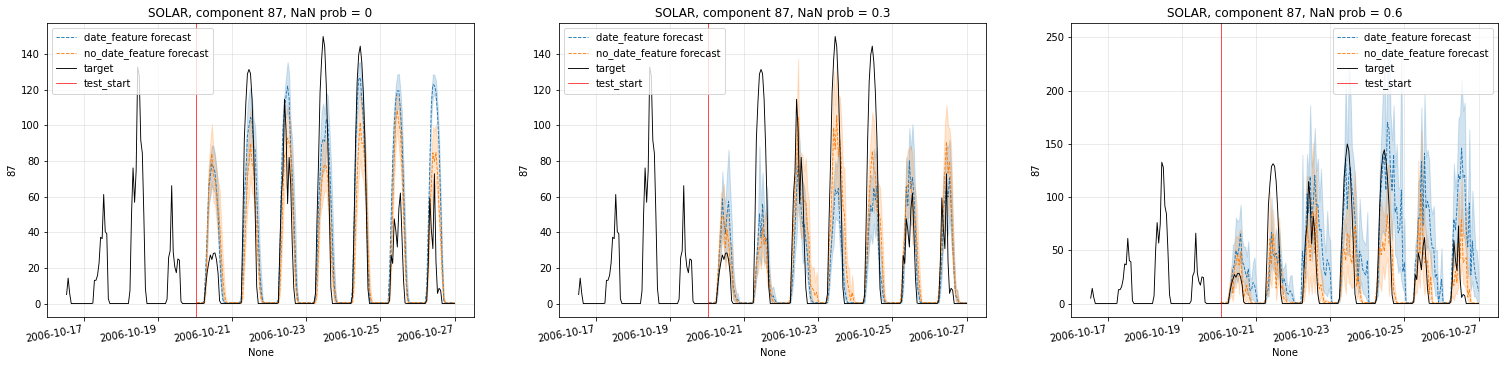

In [223]:
for component in solar_components[:3]:
    
    fig, ax = plt.subplots(1, 3, figsize=(26, 6))
    
    for idx, nans_prob in enumerate([0, 0.3, 0.6]):

        for model in solar_forecasts['model'].unique():

            cur_forecasts = solar_forecasts[(solar_forecasts['model'] == model) & (solar_forecasts['nans_prob'] == nans_prob)]

            sns.lineplot(
                x=cur_forecasts.index,
                y=cur_forecasts[component],
                label=f"{model} forecast",
                linestyle='--', 
                linewidth=0.9, 
                ax=ax[idx]
            )

        solar_targets[-1][component][-int(solar_test_length*1.5):].plot(label='target', color='black', linewidth=0.9, ax=ax[idx])
        ax[idx].axvline(cur_forecasts.index[0], label='test_start', color='red', linewidth=0.7)


        ax[idx].legend()
        ax[idx].grid(alpha=0.3)
        ax[idx].set_title(f"SOLAR, component {component}, NaN prob = {nans_prob}")
        ax[idx].tick_params(axis='x', rotation=10)

### Electricity

In [224]:
# targets
electricity_targets = forecasts['trans_maf_date_feature']['electricity'][0.0]['targets']

# forecasts
electricity_forecasts_maf = to_pandas(forecasts['trans_maf_date_feature']['electricity'][0.0]['forecasts'], freq=electricity.metadata.freq)

# test length
el_test_length = len(electricity_forecasts_maf[electricity_forecasts_maf['sample'] == 1])

# dataset summary
dataset_summary(electricity, electricity_targets[0], electricity_forecasts_maf[electricity_forecasts_maf['sample'] == 1])

freq: H
prediction length: 24
n_components: 370

train start: 2014-03-19 09:00
train end: 2014-09-02 00:00
length: 4000

test start: 2014-09-01 01:00:00
test end: 2014-09-08 00:00:00
length: 168


#### Train/test periods

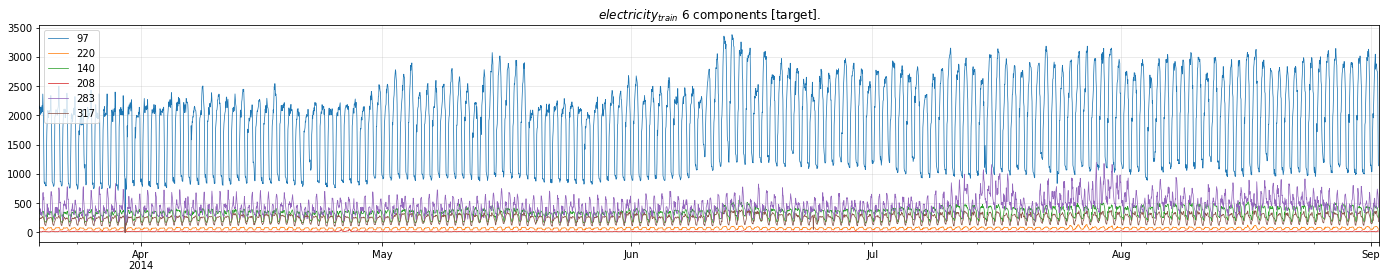

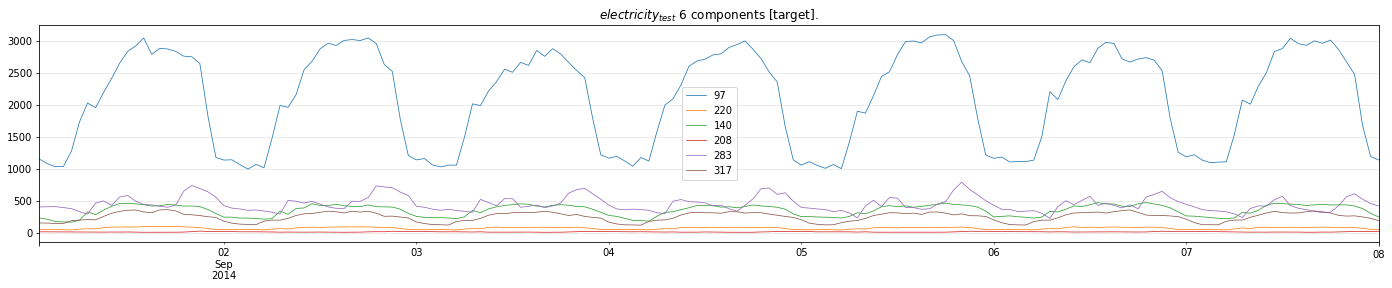

In [225]:
n = 6

electricity_components = np.random.choice(range(electricity_targets[0].shape[1]), size=n)

visualize_targets(electricity_targets[0][electricity_components], '$electricity_{train}$')
visualize_targets(electricity_targets[-1][electricity_components].iloc[-el_test_length:, :], '$electricity_{test}$')

#### Actual/forecast visualisation

In [227]:
electricity_forecasts['model'] = electricity_forecasts['model'].map(rename_map)

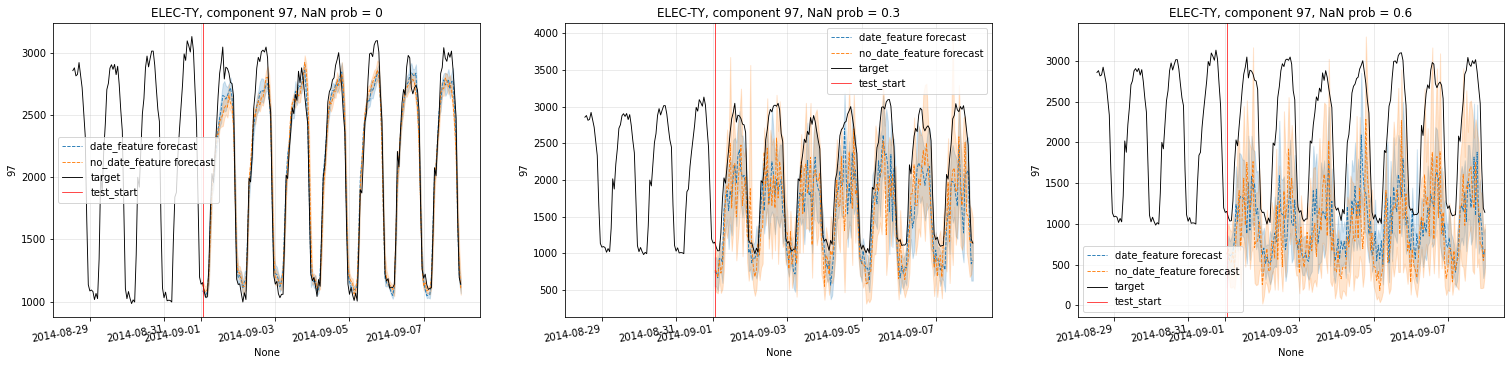

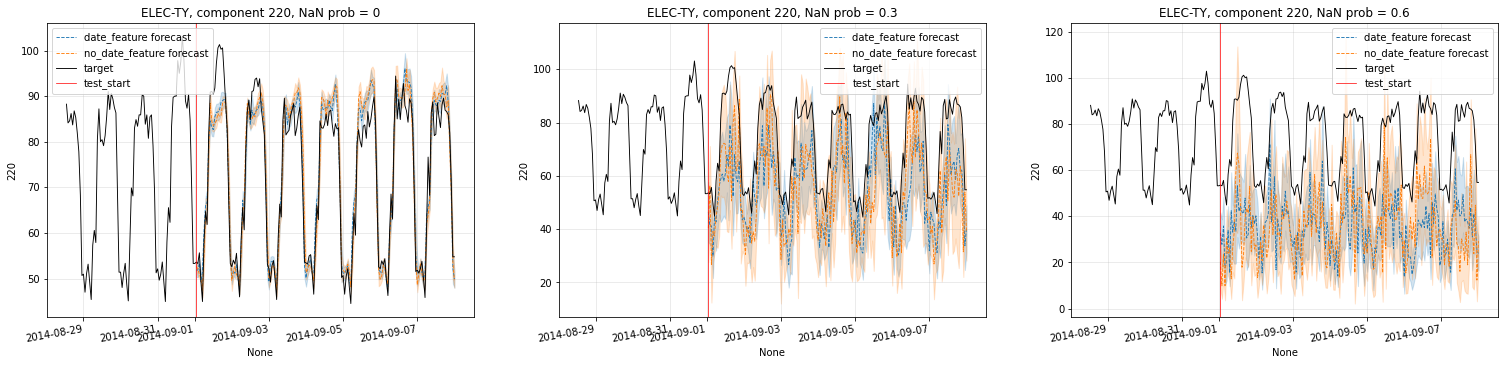

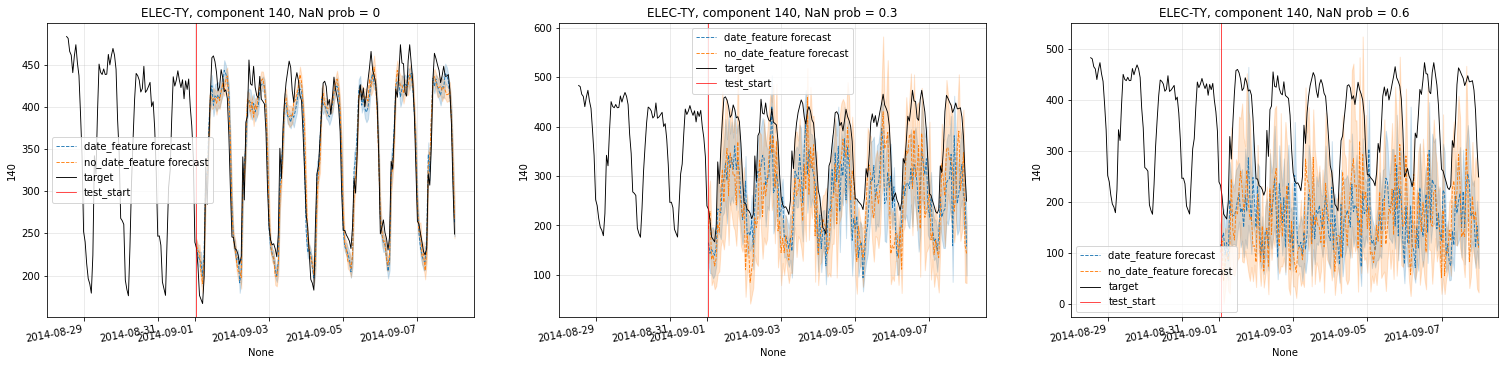

In [228]:
for component in electricity_components[:3]:
    
    fig, ax = plt.subplots(1, 3, figsize=(26, 6))
    
    for idx, nans_prob in enumerate([0, 0.3, 0.6]):

        for model in electricity_forecasts['model'].unique():

            cur_forecasts = electricity_forecasts[(electricity_forecasts['model'] == model) & (electricity_forecasts['nans_prob'] == nans_prob)]

            sns.lineplot(
                x=cur_forecasts.index,
                y=cur_forecasts[component],
                label=f"{model} forecast",
                linestyle='--', 
                linewidth=0.9, 
                ax=ax[idx]
            )

        electricity_targets[-1][component][-int(el_test_length*1.5):].plot(label='target', color='black', linewidth=0.9, ax=ax[idx])
        ax[idx].axvline(cur_forecasts.index[0], label='test_start', color='red', linewidth=0.7)


        ax[idx].legend()
        ax[idx].grid(alpha=0.3)
        ax[idx].set_title(f"ELEC-TY, component {component}, NaN prob = {nans_prob}")
        ax[idx].tick_params(axis='x', rotation=10)

### Exchange

#### Actual/forecast visualisation

In [229]:
# targets
exchange_targets = forecasts['trans_maf_date_feature']['exchange'][0.0]['targets']

# forecasts
exchange_forecasts_maf = to_pandas(forecasts['trans_maf_date_feature']['exchange'][0.0]['forecasts'], freq=exchange.metadata.freq)

# test size
ex_test_size = len(exchange_forecasts_maf[exchange_forecasts_maf['sample'] == 1])

# dataset summary
dataset_summary(exchange, exchange_targets[0], exchange_forecasts_maf[exchange_forecasts_maf['sample'] == 1])

freq: 1B
prediction length: 30
n_components: 8

train start: 1990-01-01
train end: 2013-05-20
length: 6101

test start: 2013-04-09 00:00:00
test end: 2013-11-04 00:00:00
length: 150


#### Train/test periods

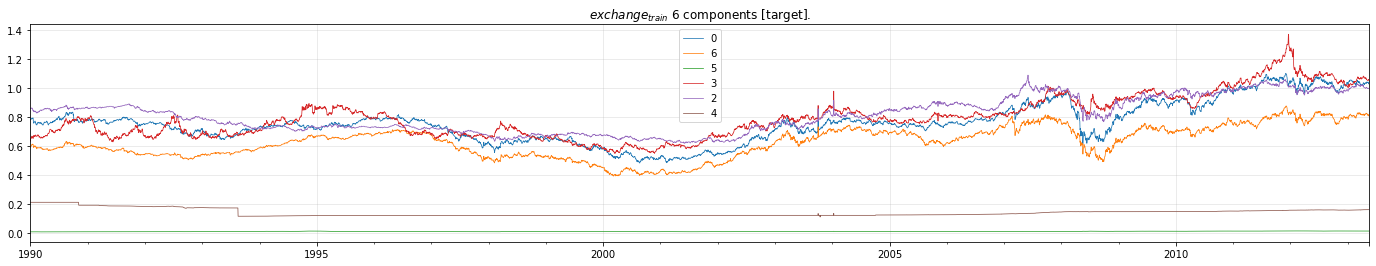

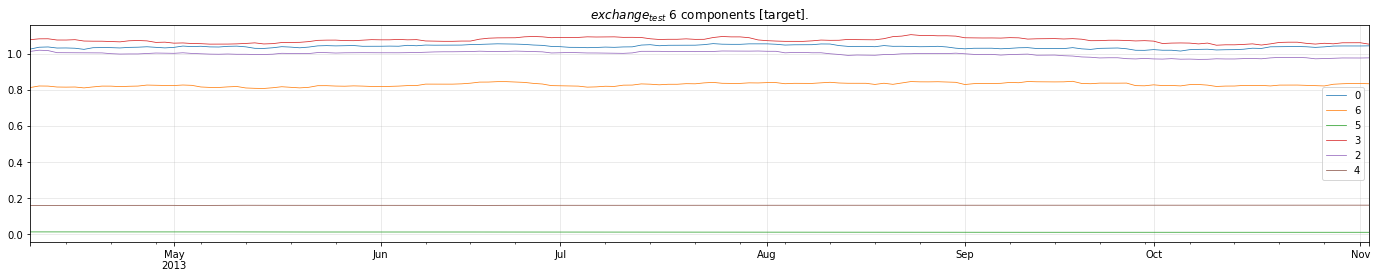

In [230]:
n = 6

exchange_components = np.random.choice(range(exchange_targets[0].shape[1]), size=n, replace=False)

visualize_targets(exchange_targets[0][exchange_components], '$exchange_{train}$')
visualize_targets(exchange_targets[-1][exchange_components].iloc[-ex_test_size:, :], '$exchange_{test}$')

#### Actual/forecast visualisation

In [231]:
exchange_forecasts['model'] = exchange_forecasts['model'].map(rename_map)

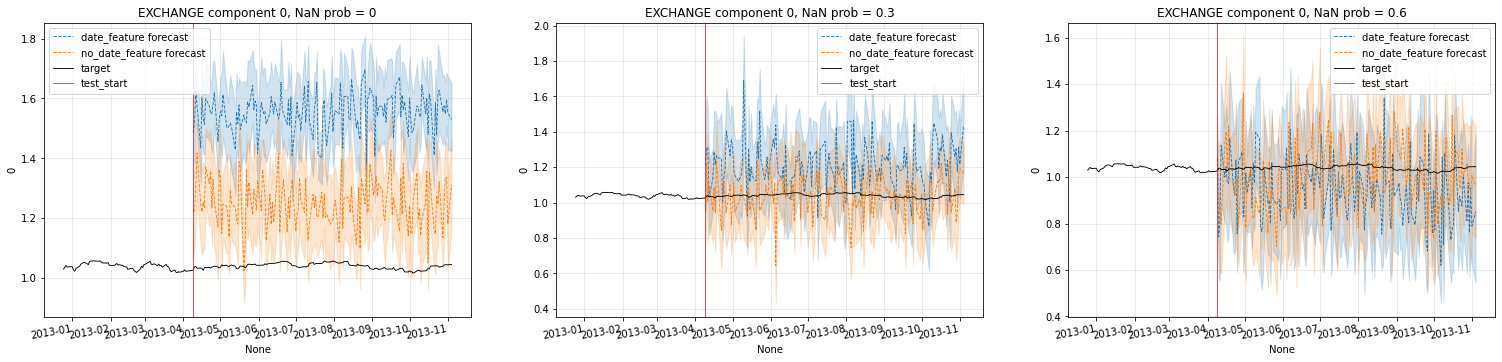

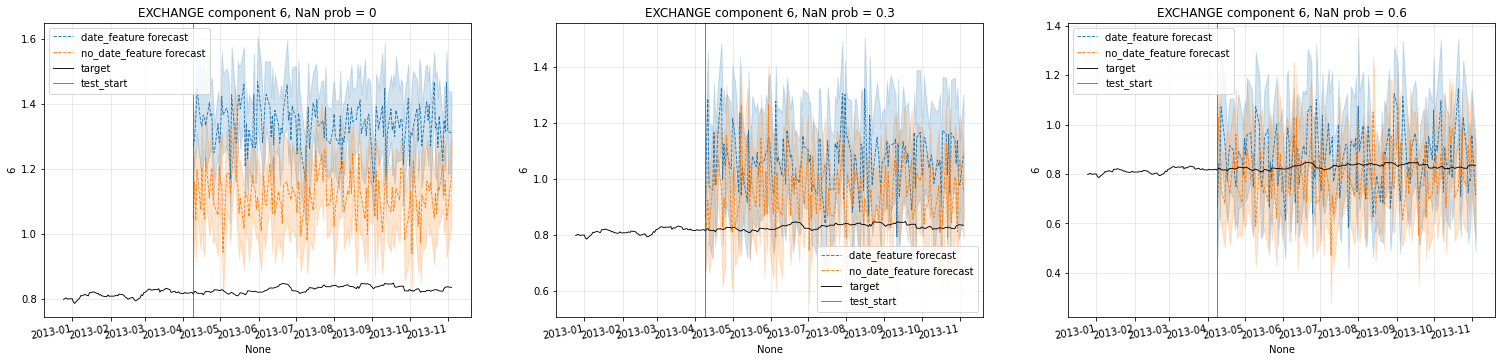

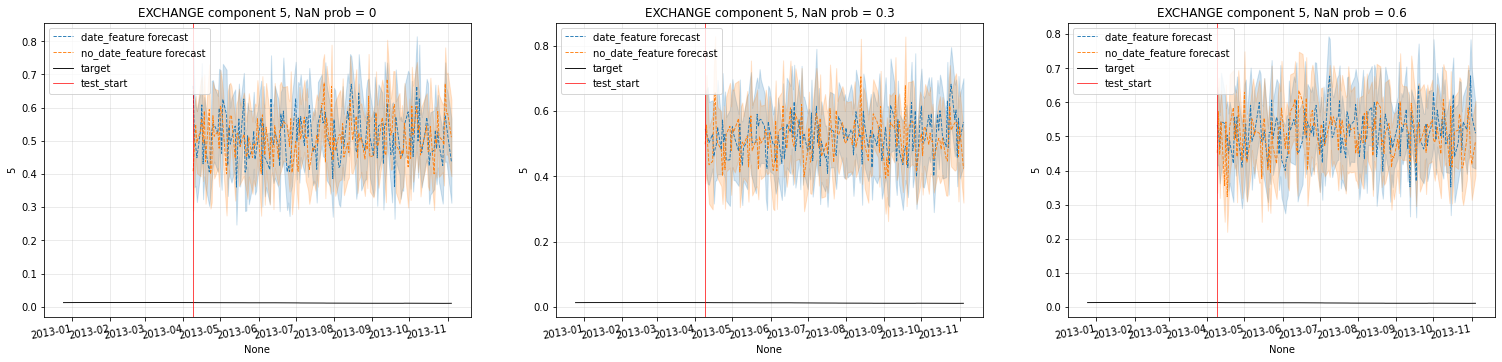

In [233]:
for component in exchange_components[:3]:
    
    fig, ax = plt.subplots(1, 3, figsize=(26, 6))
    
    for idx, nans_prob in enumerate([0, 0.3, 0.6]):

        for model in exchange_forecasts['model'].unique():

            cur_forecasts = exchange_forecasts[(exchange_forecasts['model'] == model) & (exchange_forecasts['nans_prob'] == nans_prob)]

            sns.lineplot(
                x=cur_forecasts.index,
                y=cur_forecasts[component],
                label=f"{model} forecast",
                linestyle='--', 
                linewidth=0.9, 
                ax=ax[idx]
            )

        exchange_targets[-1][component][-int(ex_test_size*1.5):].plot(label='target', color='black', linewidth=0.9, ax=ax[idx])
        ax[idx].axvline(cur_forecasts.index[0], label='test_start', color='red', linewidth=0.7)


        ax[idx].legend()
        ax[idx].grid(alpha=0.3)
        ax[idx].set_title(f"EXCHANGE component {component}, NaN prob = {nans_prob}")
        ax[idx].tick_params(axis='x', rotation=10)